Using cpu for training

--- Training Model for Assignment 1 (Function only) ---
Epoch [2000/20000], Loss: 0.00000561
Epoch [4000/20000], Loss: 0.00000039
Epoch [6000/20000], Loss: 0.00000006
Epoch [8000/20000], Loss: 0.00000004
Epoch [10000/20000], Loss: 0.00000003
Epoch [12000/20000], Loss: 0.00000002
Epoch [14000/20000], Loss: 0.00000002
Epoch [16000/20000], Loss: 0.00000001
Epoch [18000/20000], Loss: 0.00000001
Epoch [20000/20000], Loss: 0.00000001

--- Evaluating Model from Assignment 1 ---
Function Approximation MSE      : 0.00000001
Function Approximation Max Error: 0.00032602
Derivative Approximation MSE    : 0.00001279
Derivative Approximation Max Error: 0.01392183


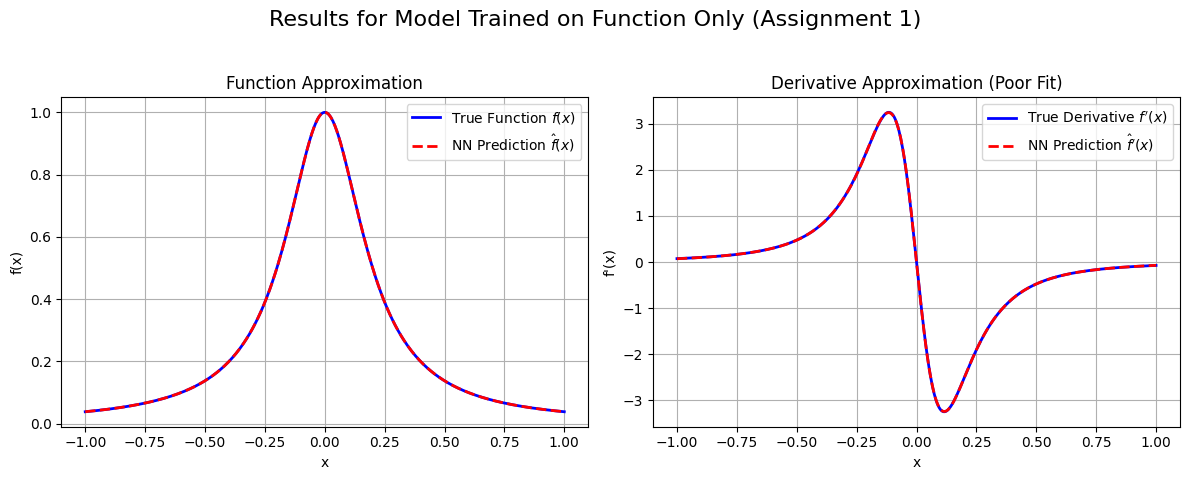

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR

def runge_function(x):
    return 1.0 / (1.0 + 25.0 * x**2)

def runge_derivative(x):
    return -50.0 * x / ((1.0 + 25.0 * x**2)**2)

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.network(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for training")

learning_rate = 0.001
num_epochs = 20000
num_train_points = 200

model_f_only = NeuralNet().to(device)
optimizer_f_only = torch.optim.Adam(model_f_only.parameters(), lr=learning_rate)
scheduler_f_only = ExponentialLR(optimizer_f_only, gamma=0.9998)
mse_loss = nn.MSELoss()

x_train_np = np.random.uniform(-1, 1, num_train_points).reshape(-1, 1)
y_train_np = runge_function(x_train_np)
x_train = torch.tensor(x_train_np, dtype=torch.float32, requires_grad=True).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.float32).to(device)

print("\n--- Training Model for Assignment 1 (Function only) ---")
for epoch in range(num_epochs):
    model_f_only.train()
    y_pred = model_f_only(x_train)
    loss = mse_loss(y_pred, y_train)

    optimizer_f_only.zero_grad()
    loss.backward()
    optimizer_f_only.step()
    scheduler_f_only.step()

    if (epoch + 1) % 2000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')

print("\n--- Evaluating Model from Assignment 1 ---")
model_f_only.eval()
x_test_np = np.linspace(-1, 1, 500).reshape(-1, 1)
x_test = torch.tensor(x_test_np, dtype=torch.float32, requires_grad=True).to(device)

y_true_f = runge_function(x_test_np)
y_true_d = runge_derivative(x_test_np)

y_pred_f = model_f_only(x_test)
y_pred_d = torch.autograd.grad(y_pred_f, x_test, grad_outputs=torch.ones_like(y_pred_f))[0]

y_pred_f_np = y_pred_f.cpu().detach().numpy()
y_pred_d_np = y_pred_d.cpu().detach().numpy()

mse_f = np.mean((y_true_f - y_pred_f_np)**2)
max_err_f = np.max(np.abs(y_true_f - y_pred_f_np))
mse_d = np.mean((y_true_d - y_pred_d_np)**2)
max_err_d = np.max(np.abs(y_true_d - y_pred_d_np))

print(f"Function Approximation MSE      : {mse_f:.8f}")
print(f"Function Approximation Max Error: {max_err_f:.8f}")
print(f"Derivative Approximation MSE    : {mse_d:.8f}")
print(f"Derivative Approximation Max Error: {max_err_d:.8f}")

plt.figure(figsize=(12, 5))
plt.suptitle('Results for Model Trained on Function Only (Assignment 1)', fontsize=16)

plt.subplot(1, 2, 1)
plt.plot(x_test_np, y_true_f, 'b-', label='True Function $f(x)$', linewidth=2)
plt.plot(x_test_np, y_pred_f_np, 'r--', label=r'NN Prediction $\hat{f}(x)$', linewidth=2)
plt.title('Function Approximation')
plt.xlabel('x'); plt.ylabel('f(x)'); plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x_test_np, y_true_d, 'b-', label="True Derivative $f'(x)$", linewidth=2)
plt.plot(x_test_np, y_pred_d_np, 'r--', label=r"NN Prediction $\hat{f}'(x)$", linewidth=2)
plt.title('Derivative Approximation (Poor Fit)')
plt.xlabel('x'); plt.ylabel("f'(x)"); plt.legend(); plt.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

如圖所示，神經網路成功地學習了 Runge 函數。預測曲線（紅色虛線）與真實函數曲線（藍色實線）幾乎完全重疊，擬合很成功。
導數逼近 (右圖)：乍看之下，模型對導數 f'(x) 的逼近效果也出乎意料地好。

預測的導數曲線（紅色虛線）成功捕捉了真實導數（藍色實線）的整體形狀、零點位置以及極值點的大致位置。從視覺上看，兩條曲線的差異非常微小。

但檢視量化的誤差指標時:
Function Approximation MSE      : 0.00000001
Function Approximation Max Error: 0.00032602
Derivative Approximation MSE    : 0.00001279
Derivative Approximation Max Error: 0.01392183
從數值上看，導數的均方誤差 (MSE) 比函數的均方誤差大了超過 100 倍。最大誤差的差距也同樣顯著。

一個在函數值上表現優異的模型，不保證其導數也能被準確地近似。